# Задание
1. Реализайте архитектуру GAN на датасете FashionMNIST, где генератор будет написан на архитектуре сверточной сети
2. Реализуйте архитектуру сверточной нейронной сети, которая будет обучена на датасете FashionMNIST, для классификации ваших сгенерированных изображений
3. Прокомментировать цикл обучения (дать комментарии кода процесса обучения)

# Оценка будет снижена, если
1) Архитектура генератора написана без использование сверточных слоев
2) Обучение модели написано не для GPU
3) Нет никаких комментариев в работе

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torch import nn

In [2]:
torch.manual_seed(123)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

In [4]:
train_set = torchvision.datasets.FashionMNIST(root='./', download = True, train =True, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.70MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.20MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size, shuffle = True)

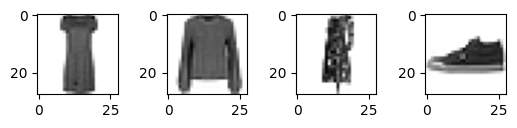

In [6]:
real_samples, labels = next(iter(train_loader))

for i in range(4):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(real_samples[i].reshape(28,28), cmap = 'gray_r')

In [7]:
class D(nn.Module):
  def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Первый свёрточный слой: 1 -> 64 канала
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Второй свёрточный слой: 64 -> 128 канала
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Третий свёрточный слой: 128 -> 256 канала
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Преобразование в вектор и классификация
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid()

        )

  def forward(self, x):
      return self.model(x)

In [8]:
class G(nn.Module):
  def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Преобразование входного шума в тензор 128 каналов 7x7
            nn.Linear(100, 128 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, 7, 7)),

            # Свёрточный транспонированный слой 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Свёрточный транспонированный слой 2
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()

        )

  def forward(self, x):
      return self.model(x)

In [9]:
num_epoch = 50
lr = 0.0002
loss_function = nn.BCELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = G().to(device)
discriminator = D().to(device)

optimizer_d = torch.optim.Adam(discriminator.parameters(),lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(),lr=lr)

In [10]:
# Обучение
for epoch in range(num_epoch):
    for i, (real_samples, _) in enumerate(train_loader):

        # Обучение дискриминатора

        # Подготовка данных
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)
        real_labels = torch.ones((batch_size, 1)).to(device)
        generated_labels = torch.zeros((batch_size, 1)).to(device)

        # Реальные данные
        outputs = discriminator(real_samples)
        loss_real = loss_function(outputs, real_labels)

        # Сгенерированные данные
        noise_samples = torch.randn(batch_size, 100).to(device)
        generated_images = generator(noise_samples)
        outputs = discriminator(generated_images.detach())
        loss_generated = loss_function(outputs, generated_labels)

        # Итоговые потери дискриминатора
        loss_discriminator = loss_real + loss_generated
        optimizer_d.zero_grad()
        loss_discriminator.backward()
        optimizer_d.step()

        # Обучение генератора

        noise_samples = torch.randn(batch_size, 100).to(device)
        generated_images = generator(noise_samples)
        outputs = discriminator(generated_images)
        loss_generator = loss_function(outputs, real_labels)
        optimizer_g.zero_grad()
        loss_generator.backward()
        optimizer_g.step()

        # Вывод потерь
        if i % 469 == 0:
          print(f'{epoch} LOSS D: {loss_discriminator}')
          print(f'{epoch} LOSS G: {loss_generator}')

0 LOSS D: 1.4529199600219727
0 LOSS G: 1.1416970491409302
1 LOSS D: 0.0006997620221227407
1 LOSS G: 10.751520156860352
2 LOSS D: 0.08482174575328827
2 LOSS G: 6.227238655090332
3 LOSS D: 0.023081528022885323
3 LOSS G: 5.748475074768066
4 LOSS D: 0.07671010494232178
4 LOSS G: 6.0322136878967285
5 LOSS D: 0.04752707481384277
5 LOSS G: 6.162535190582275
6 LOSS D: 0.03240444138646126
6 LOSS G: 5.392666339874268
7 LOSS D: 0.13330909609794617
7 LOSS G: 6.619964599609375
8 LOSS D: 0.023809947073459625
8 LOSS G: 3.471994400024414
9 LOSS D: 0.08074983209371567
9 LOSS G: 3.846592664718628
10 LOSS D: 0.03686632961034775
10 LOSS G: 4.032467842102051
11 LOSS D: 0.1725359410047531
11 LOSS G: 4.462367534637451
12 LOSS D: 0.06080387905240059
12 LOSS G: 4.279048919677734
13 LOSS D: 0.06254427134990692
13 LOSS G: 4.94223165512085
14 LOSS D: 0.09359882026910782
14 LOSS G: 3.2123489379882812
15 LOSS D: 0.10716310888528824
15 LOSS G: 4.926117897033691
16 LOSS D: 0.1376783400774002
16 LOSS G: 3.604162216186

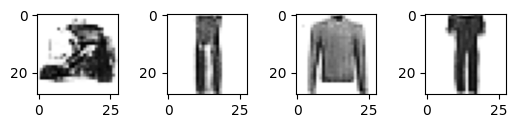

In [11]:
noise_samples = torch.randn(batch_size,100).to(device)
generated_samples = generator(noise_samples)
generated_samples = generated_samples.detach().cpu()

for i in range(4):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(generated_samples[i].reshape(28,28), cmap = 'gray_r')

In [12]:
class Сlassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # Первый свёрточный слой: 1 -> 32 канала
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Второй свёрточный слой: 32 -> 64 канала
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Преобразование в вектор и классификация
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Загрузка реальных и сгенерированных данных для обучения классификатора
classifier = Сlassifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epoch):
    for i, (real_samples, labels) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        labels = labels.to(device)

        # Предсказания и вычисление ошибки
        outputs = classifier(real_samples)
        loss = criterion(outputs, labels)

        # Обновление параметров
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вывод потерь
        if i % 469 == 0:
          print(f'{epoch} LOSS D: {loss}')

0 LOSS D: 2.2997679710388184
1 LOSS D: 0.31809553503990173
2 LOSS D: 0.37760719656944275
3 LOSS D: 0.31387045979499817
4 LOSS D: 0.26570776104927063
5 LOSS D: 0.2976268231868744
6 LOSS D: 0.2986440062522888
7 LOSS D: 0.2796589732170105
8 LOSS D: 0.2852807939052582
9 LOSS D: 0.2840791940689087
10 LOSS D: 0.2647465467453003
11 LOSS D: 0.21964164078235626
12 LOSS D: 0.16025228798389435
13 LOSS D: 0.08178988099098206
14 LOSS D: 0.15653319656848907
15 LOSS D: 0.16572850942611694
16 LOSS D: 0.22042949497699738
17 LOSS D: 0.1755257248878479
18 LOSS D: 0.2258443385362625
19 LOSS D: 0.08822748810052872
20 LOSS D: 0.129951611161232
21 LOSS D: 0.1362360715866089
22 LOSS D: 0.12945711612701416
23 LOSS D: 0.19108647108078003
24 LOSS D: 0.10997723788022995
25 LOSS D: 0.11085367202758789
26 LOSS D: 0.07244722545146942
27 LOSS D: 0.09233007580041885
28 LOSS D: 0.20425134897232056
29 LOSS D: 0.08254454284906387
30 LOSS D: 0.08183423429727554
31 LOSS D: 0.14274843037128448
32 LOSS D: 0.08737325668334961